In [1]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints

import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

In [2]:
assert pyro.__version__.startswith('1.8.1')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
#smoke_test = 'CI' in os.environ

In [3]:
device = torch.device('cpu')
# if torch.cuda.is_available():
#     device = torch.device('cuda:0')

In [4]:
from torch.distributions.utils import (_sum_rightmost, broadcast_all,
                                       lazy_property, tril_matrix_to_vec,
                                       vec_to_tril_matrix)

In [5]:
def make_pd_mat(size, tensor_of_vectors):
    x = vec_to_tril_matrix(tensor_of_vectors)
    for idx in range(size):
        x[:, idx, idx] = torch.exp(x[:, idx, idx])
    z_scale = torch.bmm(x, x.transpose(1, 2))
    return z_scale

In [6]:
import torch.nn.functional as F
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.input_dim = input_dim
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim[0]*input_dim[1], hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        val = int((z_dim**2 + z_dim) / 2)
        self.fc22 = nn.Linear(hidden_dim, val) # z_dim**2)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # then compute the hidden units
        hidden = self.fc1(x.reshape(x.shape[0], self.input_dim[0] * self.input_dim[1]))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        A_vect = self.fc22(hidden)
        A = vec_to_tril_matrix(A_vect)
        z_scale = torch.bmm(A, A.transpose(1, 2))
        z_scale.add_(torch.eye(self.z_dim)*1e-4)
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, input_dim)
        self.fc22 = nn.Linear(hidden_dim, input_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        mu = self.fc21(hidden)
        sigma = torch.exp(self.fc22(hidden))
        return mu, sigma


# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, input_dim,
        z_dim=5, hidden_dim=250, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim=input_dim)
        # self.decoder = Decoder(z_dim, hidden_dim, input_dim=input_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, sigma, x):
        # register PyTorch module `decoder` with Pyro
        # pyro.module("decoder", self.decoder)
        
        # setup hyperparameters for prior p(z)
        mu_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
        mu_scale = torch.eye(x[0].shape[1]).reshape(
            (1,x[0].shape[1],x[0].shape[1])).repeat(x.shape[0], 1, 1)

        for i in pyro.plate("batch_loop", x.shape[0]):
            
            # sample from prior (value will be sampled by guide when computing the ELBO
            mu = pyro.sample("latent_{}".format(i), dist.MultivariateNormal(mu_loc[i,:], mu_scale[i,:,:]))
            scale = pyro.param("scale_{}".format(i), torch.eye(x[i].shape[1]).reshape(
                (1,x[i].shape[1],x[i].shape[1])))
            
            with pyro.plate("data_loop_{}".format(i), x[i].shape[0]):
                pyro.sample("obs_{}".format(i), dist.MultivariateNormal(mu, scale),
                                obs=x[i, :, :])          
            
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, sigma, x):
        
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)

        for i in pyro.plate("batch_loop", x.shape[0]):
            
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x[i].unsqueeze(0))

            # sample the latent code z
            z = pyro.sample("latent_{}".format(i), dist.MultivariateNormal(z_loc, z_scale))
            
            scale = pyro.param("scale_{}".format(i), torch.eye(x[i].shape[1]).reshape(
                (1,x[i].shape[1],x[0].shape[1])))#.repeat(x.shape[i], 1, 1))

In [7]:
# write a function to find this exact posterior 
def get_posterior_cov_mv_gaussian(n, sigma, sigma_0):
    sum_part = sigma_0 + 1/n * sigma
    sum_part = np.linalg.inv(sum_part)
    p1 = np.matmul(sigma_0, sum_part)
    p2 = np.matmul(p1, 1/n * sigma)
    return(p2)

def get_posterior_mean_mv_gaussian(n, sigma, sigma_0, mu_0, data):
    sum_part = sigma_0 + 1/n * sigma
    sum_part = np.linalg.inv(sum_part)
    
    middle_part = data.mean(axis=0)
    
    p1 = np.matmul(sigma_0, sum_part)
    p2 = np.matmul(p1, middle_part)
    
    p3 = np.matmul(1/n * sigma, sum_part)
    p4 = np.matmul(p3, mu_0)
    return(p2 + p4)

In [8]:
def multivar_random(size, normal_params, gamma_params, num_samples):   

    # simulate two random covariance matrices (PSD) for sigma and sigma_0
    mat = np.random.gamma(gamma_params[0], gamma_params[1], size=size**2).reshape((size, size))
    sigma_mat = torch.tensor(np.dot(mat, mat.transpose()))
    
    mat_0 = np.random.gamma(gamma_params[2], gamma_params[3], size=size**2).reshape((size, size))
    sigma_mat_0 = torch.tensor(np.dot(mat_0, mat_0.transpose()))
    
    # simulate some random means
    mu_vector = torch.tensor(np.random.multivariate_normal(normal_params, sigma_mat_0, size=1))[0]

    # now simulate multivariate gaussian
    data = torch.tensor(np.random.multivariate_normal(mu_vector, sigma_mat, size=num_samples).astype("float32"))
    
    return(data, mu_vector, sigma_mat, sigma_mat_0)

In [9]:
X = []
means = []
sigma_mats = []
sigma_0s = []
for idx in range(10000):
    random_means = np.random.sample(size=5) 
    
    data, mu_vector, sigma_mat, sigma_mat_0 = multivar_random(5, [1]*5, [1,1,1,1], num_samples=500)
    X.append(data)
    means.append(mu_vector)
    sigma_mats.append(sigma_mat)
    sigma_0s.append(sigma_mat_0)

In [10]:
# clear param store
pyro.clear_param_store()

no_instances = 20000
input_dim = (500, 5)
mu = stats.norm.rvs(size=input_dim)

# setup the VAE
vae = VAE(use_cuda=False, input_dim=input_dim, z_dim=5)

adam_args = {"lr": 0.00001}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
train_loader = DataLoader(X, batch_size=5000, shuffle=True,
     num_workers=1, pin_memory=True, drop_last=False)

train_elbo = []

for epoch in range(50):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    print("Epoch: ", epoch, end = "\r")
    for x in train_loader:
        # x = x.cuda()
        epoch_loss += svi.step(torch.eye(input_dim[1]), x)

    # report training diagnostics
    if not epoch % 2:
        normalizer_train = len(train_loader.dataset)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo.append(total_epoch_loss_train)
        print("[epoch %03d]  average training loss: %.4f" %
             (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 39812.0973
[epoch 002]  average training loss: 34712.5479
[epoch 004]  average training loss: 30948.6877
[epoch 006]  average training loss: 28017.6813
[epoch 008]  average training loss: 26384.3243
[epoch 010]  average training loss: 25282.6669
[epoch 012]  average training loss: 24301.7884
[epoch 014]  average training loss: 23834.2562
[epoch 016]  average training loss: 23161.1112
[epoch 018]  average training loss: 22636.9219
[epoch 020]  average training loss: 22347.6311
[epoch 022]  average training loss: 22024.5932
[epoch 024]  average training loss: 21584.5084
[epoch 026]  average training loss: 21350.1521
[epoch 028]  average training loss: 21084.4398
[epoch 030]  average training loss: 20913.1605
[epoch 032]  average training loss: 20836.8875
[epoch 034]  average training loss: 20699.8835
[epoch 036]  average training loss: 20542.3478
[epoch 038]  average training loss: 20465.3501
[epoch 040]  average training loss: 20522.1383
[epoch 042]  

Text(0, 0.5, 'ELBO loss')

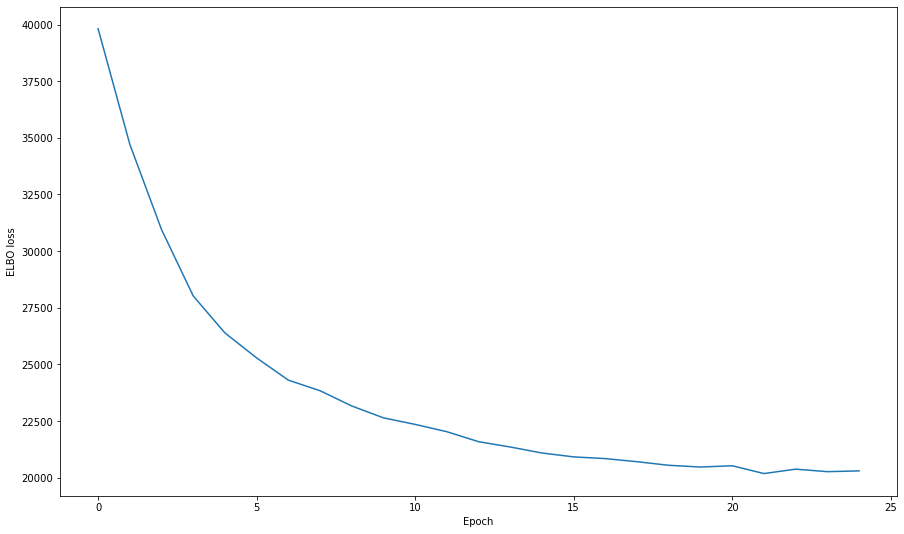

In [11]:
plt.figure(figsize=(15, 9))
plt.plot([i for i in range(len(train_elbo))], train_elbo)
plt.xlabel("Epoch")
plt.ylabel("ELBO loss")

In [12]:
count = 0
for name, value in pyro.get_param_store().items():
    print(name)

encoder$$$fc1.weight
encoder$$$fc1.bias
encoder$$$fc21.weight
encoder$$$fc21.bias
encoder$$$fc22.weight
encoder$$$fc22.bias
scale_0
scale_1
scale_2
scale_3
scale_4
scale_5
scale_6
scale_7
scale_8
scale_9
scale_10
scale_11
scale_12
scale_13
scale_14
scale_15
scale_16
scale_17
scale_18
scale_19
scale_20
scale_21
scale_22
scale_23
scale_24
scale_25
scale_26
scale_27
scale_28
scale_29
scale_30
scale_31
scale_32
scale_33
scale_34
scale_35
scale_36
scale_37
scale_38
scale_39
scale_40
scale_41
scale_42
scale_43
scale_44
scale_45
scale_46
scale_47
scale_48
scale_49
scale_50
scale_51
scale_52
scale_53
scale_54
scale_55
scale_56
scale_57
scale_58
scale_59
scale_60
scale_61
scale_62
scale_63
scale_64
scale_65
scale_66
scale_67
scale_68
scale_69
scale_70
scale_71
scale_72
scale_73
scale_74
scale_75
scale_76
scale_77
scale_78
scale_79
scale_80
scale_81
scale_82
scale_83
scale_84
scale_85
scale_86
scale_87
scale_88
scale_89
scale_90
scale_91
scale_92
scale_93
scale_94
scale_95
scale_96
scale_97
scal

In [13]:
vae.encoder.eval()

Encoder(
  (fc1): Linear(in_features=2500, out_features=250, bias=True)
  (fc21): Linear(in_features=250, out_features=5, bias=True)
  (fc22): Linear(in_features=250, out_features=15, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)

In [14]:
idx = 0
X[idx].shape
mean_pred = vae.encoder.forward(X[idx].unsqueeze(0))[0]
mean_act = means[idx]
print("Predicted means: {}.".format(mean_pred))
print("Actual means: {}.".format(mean_act))

Predicted means: tensor([[ 0.3033,  0.5808,  1.1685,  3.5322, -2.5217]],
       grad_fn=<AddmmBackward0>).
Actual means: tensor([ 1.7945,  1.7146,  1.7387,  1.7727, -3.0750], dtype=torch.float64).


In [15]:
x_i, mu_vector, sigma, sigma_0 = multivar_random(5, [0] * 5, [.5]*4, 500)
mean_pred = vae.encoder.forward(x_i.reshape(1, 500, 5))[0]
#should be 500?
mean_act = get_posterior_mean_mv_gaussian(50, sigma, sigma_0, mu_vector, x_i)
sigma_act = get_posterior_cov_mv_gaussian(50, sigma, sigma_0)
print("Predicted means: {}.".format(mean_pred))
print("Actual means: {}.".format(mean_act))

Predicted means: tensor([[ 0.6487, -0.1086,  0.0812,  0.2264,  0.1881]],
       grad_fn=<AddmmBackward0>).
Actual means: tensor([ 0.4214, -0.3142, -0.6086,  0.1791, -0.1024], dtype=torch.float64).


In [16]:
mean_sigma = vae.encoder.forward(x_i.reshape(1, 500, 5))[1]
mean_sigma

tensor([[[0.0249, 0.0496, 0.0590, 0.0301, 0.0163],
         [0.0496, 0.1122, 0.1111, 0.0430, 0.0289],
         [0.0590, 0.1111, 0.1521, 0.0366, 0.0309],
         [0.0301, 0.0430, 0.0366, 0.3148, 0.0744],
         [0.0163, 0.0289, 0.0309, 0.0744, 0.0549]]], grad_fn=<AddBackward0>)

In [17]:
post_sigma = get_posterior_cov_mv_gaussian(500, sigma, sigma_0)

In [25]:
mean_pred[0][0]

0.6486842

In [19]:
mean_pred = mean_pred.detach().numpy()
mean_sigma = mean_sigma.detach().numpy()
mean_act = mean_act.detach().numpy()
sigma_act = sigma_act.detach().numpy()

In [20]:
mean_act

array([ 0.42141523, -0.31418167, -0.60860279,  0.17912192, -0.1024235 ])

In [21]:
post_mean = get_posterior_mean_mv_gaussian(500, sigma, sigma_0, mu_vector, data)

In [22]:
mean_sigma[0]

array([[0.02488464, 0.04957218, 0.05897294, 0.03014101, 0.01627005],
       [0.04957218, 0.11221284, 0.11108663, 0.04298105, 0.02891169],
       [0.05897294, 0.11108663, 0.15208948, 0.03656612, 0.0309224 ],
       [0.03014101, 0.04298105, 0.03656612, 0.31477553, 0.0744321 ],
       [0.01627005, 0.02891169, 0.0309224 , 0.0744321 , 0.0548697 ]],
      dtype=float32)

## SVI

In [23]:
import logging
import os
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')
def model(loc_mean_prior_params, loc_scale_prior_params, data):
    loc = pyro.sample("loc", dist.MultivariateNormal(loc_mean_prior_params, loc_scale_prior_params))
    # for now leave the scale as the identity - can change it to Wishart in the future
    scale = pyro.param("scale", torch.eye(5, 5))
#     print(data.shape)
    with pyro.plate("data", data.shape[0]):
        return pyro.sample("obs", dist.MultivariateNormal(loc, scale), obs=data)


def parametrised_guide(loc_mean_prior_params, loc_scale_prior_params, data):
    
    mu_mu = pyro.param("mu_mu", torch.tensor(loc_mean_prior_params))
    
    mu_std = pyro.param(
        "mu_std", torch.tensor(loc_scale_prior_params) , constraint=constraints.positive_definite
    ) 

    loc = pyro.sample("loc", dist.MultivariateNormal(mu_mu, mu_std))
    scale = pyro.param("scale", torch.eye(5, 5))
#     return pyro.sample("data_dist", dist.MultivariateNormal(loc, scale))

pyro.clear_param_store()

# These should be reset each training loop.
svi = pyro.infer.SVI(
    model=model,
    guide=parametrised_guide,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(torch.zeros(5), torch.eye(5, 5), x_i)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

/var/folders/q5/tz0kh0xs3s7dcdvjv_y20d640000gn/T/ipykernel_20043/3530107018.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu_mu = pyro.param("mu_mu", torch.tensor(loc_mean_prior_params))
/var/folders/q5/tz0kh0xs3s7dcdvjv_y20d640000gn/T/ipykernel_20043/3530107018.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "mu_std", torch.tensor(loc_scale_prior_params) , constraint=constraints.positive_definite


_LinAlgError: torch.linalg_cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 5 is not positive-definite).
Trace Shapes:        
 Param Sites:        
        scale   5 5  
Sample Sites:        
     loc dist     | 5
        value     | 5
    data dist     |  
        value 500 |  

In [ ]:
for name, value in pyro.get_param_store().items():
    if name == 'mu_mu' or name == 'mu_std':
        print(name, pyro.param(name).data.cpu().numpy())

In [ ]:
mean_svi = pyro.param('mu_mu').data.cpu().numpy()
std_svi = pyro.param('mu_std').data.cpu().numpy()

In [ ]:
std_svi

In [ ]:
mean_sigma[0]

In [ ]:
mean_svi

In [ ]:
mean_act

In [ ]:
svi_mean = get_posterior_mean_mv_gaussian(500, sigma, sigma_0, mu_vector, data)
svi_sigma = get_posterior_cov_mv_gaussian(500, sigma, sigma_0)

In [ ]:
import seaborn as sns
from matplotlib.lines import Line2D

In [ ]:
tru = np.random.multivariate_normal(mean_act, sigma_act, 5000).T
avi = np.random.multivariate_normal(mean_pred[0], mean_sigma[0], 5000).T
svi = np.random.multivariate_normal(mean_svi, std_svi, 5000).T
fig, axes = plt.subplots(5,5, figsize=(25,25))
for idx, val in enumerate(sigma_act[0]):
    for idx2, val2 in enumerate(sigma_act[0]):
        if idx==idx2:
            sns.kdeplot(svi[idx], label='SVI', color='Green', ax=axes[idx2,idx])
            sns.kdeplot(avi[idx], label='AVI', color='Red', ax=axes[idx2,idx])
            sns.kdeplot(tru[idx], label='True', color='Blue', ax=axes[idx2,idx]).set(title = f'$x_{idx2}$')           
        else:
            if idx<=4 and idx2<=4:
                sns.kdeplot(svi[idx2], svi[idx], label='SVI', color='Green', ax=axes[idx2,idx])
                sns.kdeplot(avi[idx2], avi[idx], label='AVI', color='Red', ax=axes[idx2,idx])
                sns.kdeplot(tru[idx2], tru[idx], label='True', color='Blue', ax=axes[idx2,idx]).set(title = f'$x_{idx2} \, & \, x_{idx}$')
custom_lines = [Line2D([0], [0], color='Green', lw=6),
                Line2D([0], [0], color='Red', lw=6),
                Line2D([0], [0], color='Blue', lw=6)]
fig.legend(custom_lines, ['SVI', 'Amortized VI', 'True Posterior'], loc = 'upper center', prop={'size': 35})                 

## prLDA

In [31]:
import math
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import os
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

assert pyro.__version__.startswith('1.8.1')
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [34]:
def model(counts):
    theta = pyro.sample('theta', dist.Dirichlet(torch.ones(6)))
    total_count = int(counts.sum())
    pyro.sample('counts', dist.Multinomial(total_count, theta), obs=counts)

data = torch.tensor([5, 4, 2, 5, 6, 5, 3, 3, 1, 5, 5, 3, 5, 3, 5, \
                     3, 5, 5, 3, 5, 5, 3, 1, 5, 3, 3, 6, 5, 5, 6])
counts = torch.unique(data, return_counts=True)[1].float()

nuts_kernel = NUTS(model)
num_samples, warmup_steps = (1000, 200) if not smoke_test else (10, 10)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(counts)
hmc_samples = {k: v.detach().cpu().numpy()
               for k, v in mcmc.get_samples().items()}

Sample: 100%|█| 1200/1200 [00:07, 163.59it/s, step size=5.33e-01, acc. prob=0.92


In [35]:
means = hmc_samples['theta'].mean(axis=0)
stds = hmc_samples['theta'].std(axis=0)
print('Inferred dice probabilities from the data (68% confidence intervals):')
for i in range(6):
    print('%d: %.2f ± %.2f' % (i + 1, means[i], stds[i]))

Inferred dice probabilities from the data (68% confidence intervals):
1: 0.08 ± 0.05
2: 0.06 ± 0.04
3: 0.28 ± 0.07
4: 0.06 ± 0.04
5: 0.42 ± 0.08
6: 0.11 ± 0.05


In [36]:
news = fetch_20newsgroups(subset='all')
vectorizer = CountVectorizer(max_df=0.5, min_df=20, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(news['data']).toarray())

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index

/Users/bennetthellman/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))

Dictionary size: 12722
Corpus size: torch.Size([18846, 12722])


In [37]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)


class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

    def model(self, docs):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T

In [38]:
# setting global variables
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_topics = 20 if not smoke_test else 3
docs = docs.float().to(device)
batch_size = 32
learning_rate = 1e-3
num_epochs = 50 if not smoke_test else 1

In [40]:
pyro.clear_param_store()

prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,
    hidden=100 if not smoke_test else 10,
    dropout=0.2
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(docs.shape[0] / batch_size)) if not smoke_test else 1

bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_docs = docs[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_docs)
        running_loss += loss / batch_docs.size(0)

    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

100%|██████████████████████| 50/50 [10:09<00:00, 12.19s/it, epoch_loss=3.71e+05]


In [46]:
#!pip install wordcloud

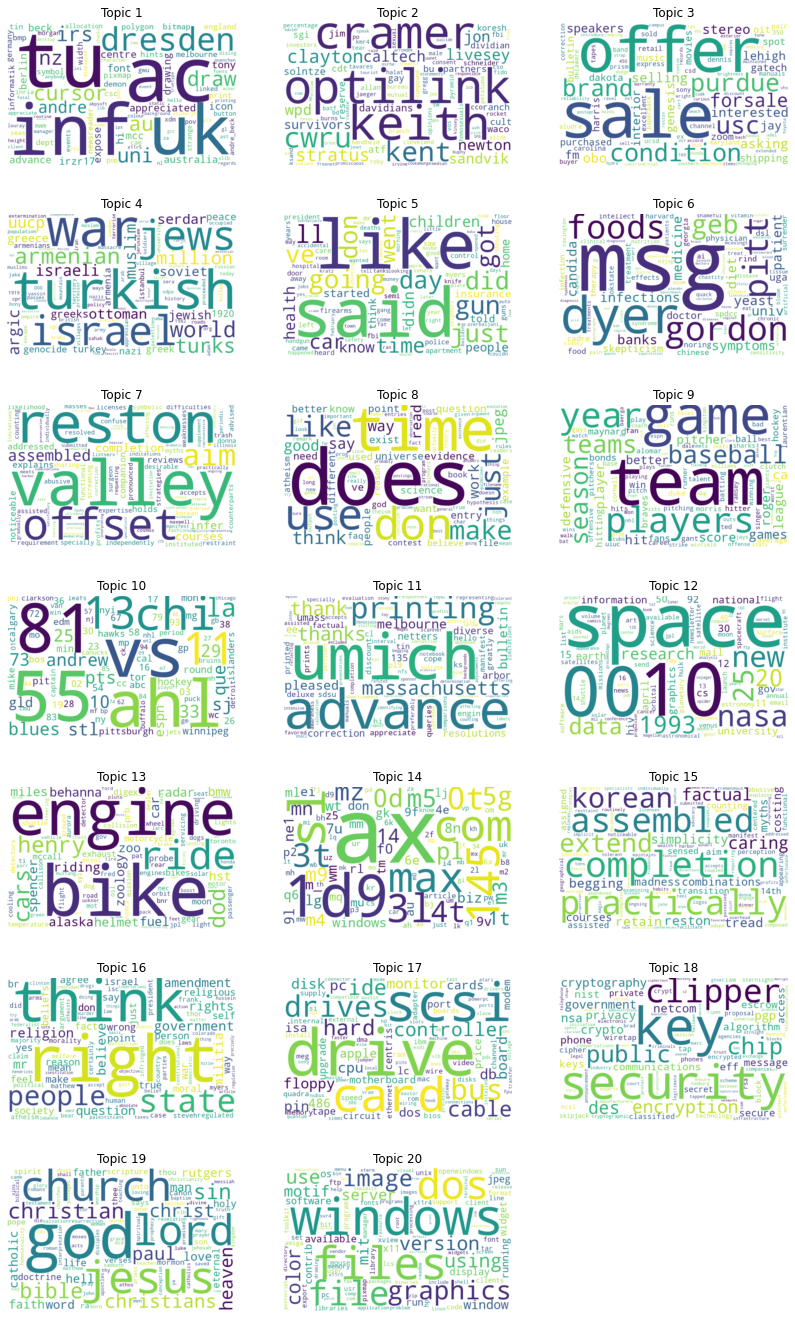

In [44]:
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

if not smoke_test:
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    beta = prodLDA.beta()
    fig, axs = plt.subplots(7, 3, figsize=(14, 24))
    for n in range(beta.shape[0]):
        i, j = divmod(n, 3)
        plot_word_cloud(beta[n], axs[i, j], vocab, n)
    axs[-1, -1].axis('off');

    plt.show()

In [45]:
prodLDA

ProdLDA(
  (encoder): Encoder(
    (drop): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=12722, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fcmu): Linear(in_features=100, out_features=20, bias=True)
    (fclv): Linear(in_features=100, out_features=20, bias=True)
    (bnmu): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (bnlv): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (decoder): Decoder(
    (beta): Linear(in_features=20, out_features=12722, bias=False)
    (bn): BatchNorm1d(12722, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
)

# Amortized LDA

In [48]:
#https://github.com/pyro-ppl/pyro/blob/dev/examples/lda.py

In [ ]:
"""
This example implements amortized Latent Dirichlet Allocation [1],
demonstrating how to marginalize out discrete assignment variables in a Pyro
model. This model and inference algorithm treat documents as vectors of
categorical variables (vectors of word ids), and collapses word-topic
assignments using Pyro's enumeration. We use PyTorch's reparametrized Gamma and
Dirichlet distributions [2], avoiding the need for Laplace approximations as in
[1]. Following [1] we use the Adam optimizer and clip gradients.
**References:**
[1] Akash Srivastava, Charles Sutton. ICLR 2017.
    "Autoencoding Variational Inference for Topic Models"
    https://arxiv.org/pdf/1703.01488.pdf
[2] Martin Jankowiak, Fritz Obermeyer. ICML 2018.
    "Pathwise gradients beyond the reparametrization trick"
    https://arxiv.org/pdf/1806.01851.pdf
"""
import argparse
import functools
import logging

import torch
from torch import nn
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.optim import ClippedAdam

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)


# This is a fully generative model of a batch of documents.
# data is a [num_words_per_doc, num_documents] shaped array of word ids
# (specifically it is not a histogram). We assume in this simple example
# that all documents have the same number of words.
def model(data=None, args=None, batch_size=None):
    # Globals.
    with pyro.plate("topics", args.num_topics):
        topic_weights = pyro.sample(
            "topic_weights", dist.Gamma(1.0 / args.num_topics, 1.0)
        )
        topic_words = pyro.sample(
            "topic_words", dist.Dirichlet(torch.ones(args.num_words) / args.num_words)
        )

    # Locals.
    with pyro.plate("documents", args.num_docs) as ind:
        if data is not None:
            with pyro.util.ignore_jit_warnings():
                assert data.shape == (args.num_words_per_doc, args.num_docs)
            data = data[:, ind]
        doc_topics = pyro.sample("doc_topics", dist.Dirichlet(topic_weights))
        with pyro.plate("words", args.num_words_per_doc):
            # The word_topics variable is marginalized out during inference,
            # achieved by specifying infer={"enumerate": "parallel"} and using
            # TraceEnum_ELBO for inference. Thus we can ignore this variable in
            # the guide.
            word_topics = pyro.sample(
                "word_topics",
                dist.Categorical(doc_topics),
                infer={"enumerate": "parallel"},
            )
            data = pyro.sample(
                "doc_words", dist.Categorical(topic_words[word_topics]), obs=data
            )

    return topic_weights, topic_words, data


# We will use amortized inference of the local topic variables, achieved by a
# multi-layer perceptron. We'll wrap the guide in an nn.Module.
def make_predictor(args):
    layer_sizes = (
        [args.num_words]
        + [int(s) for s in args.layer_sizes.split("-")]
        + [args.num_topics]
    )
    logging.info("Creating MLP with sizes {}".format(layer_sizes))
    layers = []
    for in_size, out_size in zip(layer_sizes, layer_sizes[1:]):
        layer = nn.Linear(in_size, out_size)
        layer.weight.data.normal_(0, 0.001)
        layer.bias.data.normal_(0, 0.001)
        layers.append(layer)
        layers.append(nn.Sigmoid())
    layers.append(nn.Softmax(dim=-1))
    return nn.Sequential(*layers)


def parametrized_guide(predictor, data, args, batch_size=None):
    # Use a conjugate guide for global variables.
    topic_weights_posterior = pyro.param(
        "topic_weights_posterior",
        lambda: torch.ones(args.num_topics),
        constraint=constraints.positive,
    )
    topic_words_posterior = pyro.param(
        "topic_words_posterior",
        lambda: torch.ones(args.num_topics, args.num_words),
        constraint=constraints.greater_than(0.5),
    )
    with pyro.plate("topics", args.num_topics):
        pyro.sample("topic_weights", dist.Gamma(topic_weights_posterior, 1.0))
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))

    # Use an amortized guide for local variables.
    pyro.module("predictor", predictor)
    with pyro.plate("documents", args.num_docs, batch_size) as ind:
        data = data[:, ind]
        # The neural network will operate on histograms rather than word
        # index vectors, so we'll convert the raw data to a histogram.
        counts = torch.zeros(args.num_words, ind.size(0)).scatter_add(
            0, data, torch.ones(data.shape)
        )
        doc_topics = predictor(counts.transpose(0, 1))
        pyro.sample("doc_topics", dist.Delta(doc_topics, event_dim=1))


def main(args):
    logging.info("Generating data")
    pyro.set_rng_seed(0)
    pyro.clear_param_store()

    # We can generate synthetic data directly by calling the model.
    true_topic_weights, true_topic_words, data = model(args=args)

    # We'll train using SVI.
    logging.info("-" * 40)
    logging.info("Training on {} documents".format(args.num_docs))
    predictor = make_predictor(args)
    guide = functools.partial(parametrized_guide, predictor)
    Elbo = JitTraceEnum_ELBO if args.jit else TraceEnum_ELBO
    elbo = Elbo(max_plate_nesting=2)
    optim = ClippedAdam({"lr": args.learning_rate})
    svi = SVI(model, guide, optim, elbo)
    logging.info("Step\tLoss")
    for step in range(args.num_steps):
        loss = svi.step(data, args=args, batch_size=args.batch_size)
        if step % 10 == 0:
            logging.info("{: >5d}\t{}".format(step, loss))
    loss = elbo.loss(model, guide, data, args=args)
    logging.info("final loss = {}".format(loss))


if __name__ == "__main__":
    assert pyro.__version__.startswith("1.8.1")
    parser = argparse.ArgumentParser(
        description="Amortized Latent Dirichlet Allocation"
    )
    parser.add_argument("-t", "--num-topics", default=8, type=int)
    parser.add_argument("-w", "--num-words", default=1024, type=int)
    parser.add_argument("-d", "--num-docs", default=1000, type=int)
    parser.add_argument("-wd", "--num-words-per-doc", default=64, type=int)
    parser.add_argument("-n", "--num-steps", default=1000, type=int)
    parser.add_argument("-l", "--layer-sizes", default="100-100")
    parser.add_argument("-lr", "--learning-rate", default=0.01, type=float)
    parser.add_argument("-b", "--batch-size", default=32, type=int)
    parser.add_argument("--jit", action="store_true")
    args = parser.parse_args()
    main(args)